Define

In [1]:
import sys
import torch.utils.data as tordata
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import torch

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib as mpl
import SimpleITK as sitk

import torchvision
from datetime import datetime
from warnings import warn
from typing import Optional
# import torchvision.models as models
# %matplotlib inline
from collections import OrderedDict
import os
# from torchsummary import summary

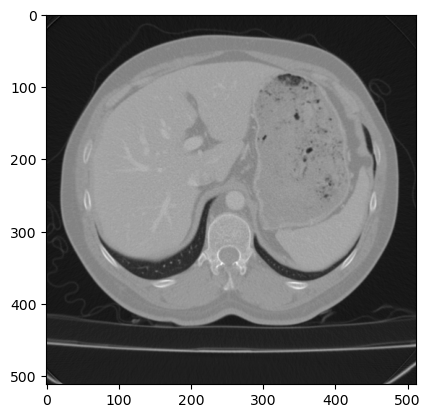

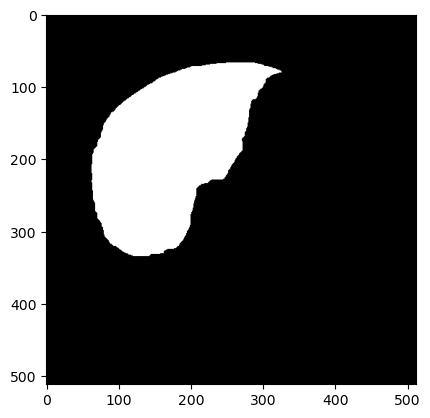

In [2]:
dicom_directory = '/bulk/liangy15/CHAOS/Train_Sets/CT/1/DICOM_anon/i0040,0000b.dcm'
ground_dir = '/bulk/liangy15/CHAOS/Train_Sets/CT/1/Ground/liver_GT_040.png'
# Read the DICOM file using pydicom
ds = sitk.ReadImage(dicom_directory)
image_np = sitk.GetArrayFromImage(ds)
ground = plt.imread(ground_dir)
plt.imshow(image_np[0], cmap='gray')
plt.show()
plt.imshow(ground, cmap='gray')
# ds = pydicom.dcmread(dicom_directory)
# image_np = ds.pixel_array



In [3]:
DATASET_PATH = '/bulk/liangy15/CHAOS/'
Train_Path = '/bulk/liangy15/CHAOS/Train_Sets/CT/'
Train_Set = [1,2,5,6,8,10,14,16,18,19,21,22,23,24,25,26,27,28,29,30]
Val_Set = [26,27,28,29,30]
Test_Set = [3,4,7,9,11,12,13,15,17,20,31,32,33,34,35,36,37,38,39,40]
Test_Path = '/bulk/liangy15/CHAOS/Test_Sets/CT/'

DataSet

In [4]:
class DataSet(tordata.Dataset):
    def __init__(self, path, set,  mode = []):
        super(DataSet, self).__init__()
        self.img_path_list = []
        self.ground_path_list = []
        self.path = path 
        self.mode = mode
        self.set = set
        self.data_path = []
        self.folder = []
        if mode == 'train':
            for i in range(len(set)):
                data_path = os.path.join(path, str(set[i]), 'DICOM_anon')
                data_path_img = os.listdir(data_path)
                try: data_path_img.sort(key=lambda x:int(x[1:5]))
                except: data_path_img.sort(key=lambda x:int(x[9:14]))
                ground_path = os.path.join(path, str(set[i]), 'Ground')
                data_path_ground = os.listdir(ground_path)
                data_path_ground.sort(key=lambda x:int(x[9:12]))
                for k in range(len(data_path_img)):
                    img_name = data_path_img[k]
                    ground_name = data_path_ground[k]
                    img_path = os.path.join(self.path, str(set[i]),'DICOM_anon', img_name)
                    ground_path = os.path.join(self.path, str(set[i]),'Ground', ground_name)
                    mask = plt.imread(ground_path)
                    if np.count_nonzero(mask) != 0:
                        self.img_path_list.append(img_path)
                        self.ground_path_list.append(ground_path)
        elif mode == 'test':
            for i in range(len(set)):
                data_path = os.path.join(path, str(set[i]), 'DICOM_anon')
                data_path_img = os.listdir(data_path)
                try: data_path_img.sort(key=lambda x:int(x[1:5]))
                except: data_path_img.sort(key=lambda x:int(x[9:14]))
                for k in range(len(data_path_img)):
                    img_name = data_path_img[k]
                    img_path = os.path.join(self.path, str(set[i]),'DICOM_anon', img_name)
                    self.img_path_list.append(img_path)
                    self.folder.append(set[i])
    def __getitem__(self, index):
        if self.mode == 'train':
            img_item_path = self.img_path_list[index]
            ground_item_path = self.ground_path_list[index]
            ds = sitk.ReadImage(img_item_path)
            data = sitk.GetArrayFromImage(ds)
            data = torch.tensor(data).float()
            data = torch.clamp(data, -170., 240.) 
            data = (data - torch.min(data))/(torch.max(data) - torch.min(data))
            mask = plt.imread(ground_item_path)
            mask = torch.tensor(mask).float()
            return data, mask
        elif self.mode == 'test':
            img_item_path = self.img_path_list[index]
            ds = sitk.ReadImage(img_item_path)
            data = sitk.GetArrayFromImage(ds)
            data = torch.tensor(data).float()
            data = torch.clamp(data, -170., 240.) 
            data = (data - torch.min(data))/(torch.max(data) - torch.min(data))
            return data, self.folder[index]
        
    def __len__(self):
        return len(self.img_path_list)
        


In [5]:
trainsource = DataSet(Train_Path, Train_Set, mode='train')
valsource = DataSet(Train_Path, Val_Set, mode='train')
testsource = DataSet(Test_Path, Test_Set, mode = 'test')
print(len(trainsource), len(valsource), len(testsource))
# img, mask = trainsource[0]
# plt.imshow(img)
# print(img.size(), mask.size())

2341 742 3533


Net

In [6]:
class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features = 32):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        #x = x.view(-1, 1)
        x = x.view(-1,1,512,512)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        output = torch.sigmoid(self.conv(dec1))
        output = output.view(output.size(0),output.size(2), output.size(3))
        return output
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


Loss

In [7]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, predict, target):
        assert predict.size() == target.size(), "the size of predict and target must be equal."
       
        # num = predict.size(0)
        # pre = predict.view(num, -1)
        # tar = target.view(num, -1)

        tp = (predict*target).sum(self.dims)
        fp = (predict*(1-target)).sum(self.dims)
        fn = ((1-predict)*target).sum(self.dims)

        nominator = 2 * tp
        denominator = 2 * tp + fp + fn

        dc = (nominator + self.smooth) / (torch.clip(denominator + self.smooth, 1e-8))
        dc = dc.mean()
        
        return 1-dc

Model

In [8]:
class Model:
    def __init__(
        self,
        lr,
        num_workers,
        batch_size,
        restore_iter,
        total_epoch,
        save_name,
        model_name,
        train_source,
        val_source,
        test_source,
        prt_path):
        
        self.lr = lr
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.restore_iter = restore_iter
        self.total_epoch = total_epoch
        self.save_name = save_name
        self.model_name = model_name
        self.train_source = train_source
        self.val_source = val_source
        self.test_source = test_source
        self.prt_path = prt_path

        net = UNet().cuda()
        self.net = nn.DataParallel(net)
        optimizer = optim.Adam([{'params':self.net.parameters(), 'lr': self.lr}])
        self.optimizer = optimizer
        loss = SoftDiceLoss()
        self.loss = nn.DataParallel(loss)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, 40, gamma=0.5)
        
        self.dice_loss = []
        self.DICELOSS = []
        self.focal_loss = []
        self.FOCALLOSS = []
    def fit(self):

        #self.load_pretrain(self.prt_path)
        
        if self.restore_iter != 0:
            self.load_model(self.restore_iter)
        self.net.train()
        train_loader = tordata.DataLoader(
                        dataset = self.train_source,
                        num_workers = self.num_workers,
                        batch_size = self.batch_size 
                        )
        
        #scaler = torch.cuda.amp.GradScaler()
        for epoch in range(self.restore_iter, self.total_epoch):
            _time1 = datetime.now()
            for i, x in enumerate(train_loader):
                imgs, masks = x
                # plt.imshow(np.array(imgs[0][0]), cmap = 'gray')
                # plt.show()
                # plt.imshow(np.array(masks[0]), cmap = 'gray')
                # plt.show()
                imgs = imgs.cuda()
                masks = masks.cuda()
                pred = self.net(imgs)
                dice_loss = self.loss(pred, masks).mean()
                focal_loss = torchvision.ops.focal_loss.sigmoid_focal_loss(pred, masks).mean()
                total_loss = (dice_loss + focal_loss)/2
                self.dice_loss.append(dice_loss.cpu().data.numpy())
                self.focal_loss.append(focal_loss.cpu().data.numpy())
                self.optimizer.zero_grad()
                total_loss.cuda().backward()
                self.optimizer.step() 
            self.scheduler.step()
                   
            print(datetime.now()-_time1)
            _time1 = datetime.now()
            self.save_model(epoch)
            print('epoch {}:'.format(epoch), end='')
            print(', dice_loss={0:.8f}'.format(np.mean(self.dice_loss)), end='')
            print(', focal_loss={0:.8f}'.format(np.mean(self.focal_loss)), end='')
            print(', lr=',self.optimizer.state_dict()['param_groups'][0]['lr'])
            sys.stdout.flush()
            self.DICELOSS.append(np.mean(self.dice_loss))
            self.FOCALLOSS.append(np.mean(self.focal_loss))
            self.dice_loss = []
            self.focal_loss = []
                
            if (epoch+1)%10 == 0:
                plt.plot(self.DICELOSS)
                plt.show()
                plt.plot(self.FOCALLOSS)
                plt.show()
            
        
        
    def validate(self, mode, batch_size=1):
        self.net.eval()
        if mode =='train':
            self.source = self.train_source
        elif mode == 'val':
            self.source = self.val_source
        else: self.source = self.test_source
        data_loader = tordata.DataLoader(
                        dataset = self.source,
                        batch_size = batch_size,
                        sampler = tordata.sampler.SequentialSampler(self.source),
                        num_workers = self.num_workers)    
        
        pred_list = list()
        mask_list = list()
        folder_list = list()
        with torch.no_grad():
            if mode == 'train' or mode == 'val':
                for i,x in enumerate(data_loader):
                    imgs, masks = x
                    pred = self.net(imgs.cuda())
                    pred_list.append(pred.data.cpu().numpy())
                    mask_list.append(masks.data.cpu().numpy())
                mask_list = np.concatenate(mask_list, 0)
                pred_list = np.concatenate(pred_list, 0)
                return pred_list, mask_list
            else:
                for i,x in enumerate(data_loader):
                    imgs, folder = x
                    if torch.count_nonzero(imgs) == 0:
                        pred = np.zeros(imgs.shape)
                    else:
                        pred = self.net(imgs.cuda())
                    pred_list.append(pred.data.cpu().numpy())
                    folder_list.append(folder)
                pred_list = np.concatenate(pred_list, 0)
                folder_list = np.concatenate(folder_list, 0)
                return pred_list, folder_list


    
    def save_model(self, i):
        torch.save(self.net.state_dict(), os.path.join(
            'model',self.model_name,
            '{}-{:0>5}-net.ptm'.format(self.save_name, i)))    
        torch.save(self.optimizer.state_dict(), os.path.join(
            'model',self.model_name,
            '{}-{:0>5}-optimizer.ptm'.format(self.save_name, i)))
        
                
    def load_model(self, restore_iter=None):
        if restore_iter is None:
             restore_iter = self.restore_iter
        self.net.load_state_dict(torch.load(os.path.join(
            '/bulk/liangy15/CHAOS/model/',self.model_name,
            '{}-{:0>5}-net.ptm'.format(self.save_name, restore_iter))), False)
        self.optimizer.load_state_dict(torch.load(os.path.join(
            '/bulk/liangy15/CHAOS/model/',self.model_name,
            '{}-{:0>5}-optimizer.ptm'.format(self.save_name, restore_iter))))
            
    def load_pretrain(self, model_path):
        self.encoder.load_state_dict(torch.load(model_path), False)

Config

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"]=" 4,5,6,7"
_lr = 1e-3
print('Initialize lr as %f' % _lr)
model_config={
    'lr': _lr,
    'num_workers': 32,
    'batch_size': 64,
    'restore_iter': 0,
    'total_epoch': 200,
    'model_name': '/bulk/liangy15/model/Unet_CT/dice+focal/dice+focal',
    'prt_path': "/home/",
    'train_source': trainsource,
    'test_source': testsource,
    'val_source': valsource
}
model_config['save_name'] = '_'.join([
        '{}'.format(model_config['model_name']),
        '{}'.format(model_config['lr']),
        '{}'.format(model_config['batch_size']),
])

os.makedirs(os.path.join('model', model_config['model_name']), exist_ok=True)
        
m = Model(**model_config)

Initialize lr as 0.001000


Train

/home/liangy15/anaconda3/envs/python==3.9/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


0:00:25.297313
epoch 0:, dice_loss=0.70148981, focal_loss=0.20538925, lr= 0.001
0:00:17.879878
epoch 1:, dice_loss=0.62627804, focal_loss=0.17664628, lr= 0.001
0:00:16.790279
epoch 2:, dice_loss=0.56226343, focal_loss=0.15990998, lr= 0.001
0:00:17.690709
epoch 3:, dice_loss=0.47939292, focal_loss=0.14605384, lr= 0.001
0:00:16.814379
epoch 4:, dice_loss=0.39392576, focal_loss=0.13640268, lr= 0.001
0:00:16.315987
epoch 5:, dice_loss=0.33652255, focal_loss=0.13159682, lr= 0.001
0:00:16.207464
epoch 6:, dice_loss=0.27972177, focal_loss=0.12855023, lr= 0.001
0:00:14.672612
epoch 7:, dice_loss=0.22375531, focal_loss=0.12556791, lr= 0.001
0:00:14.700254
epoch 8:, dice_loss=0.20348702, focal_loss=0.12504454, lr= 0.001
0:00:14.660313
epoch 9:, dice_loss=0.19543764, focal_loss=0.12449277, lr= 0.001


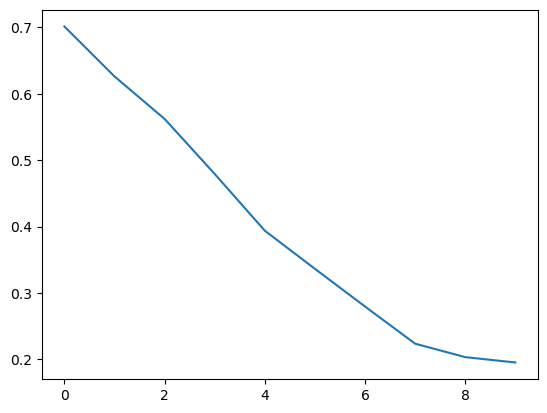

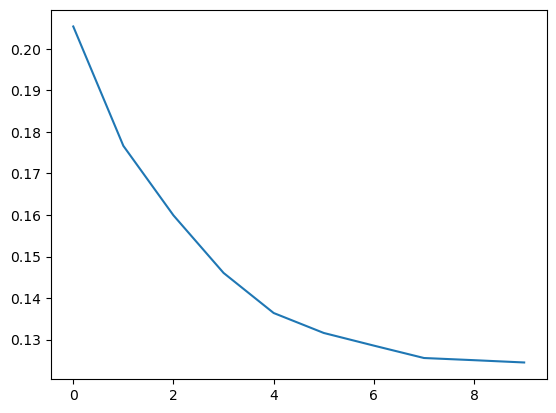

0:00:16.831565
epoch 10:, dice_loss=0.16989122, focal_loss=0.12405014, lr= 0.001
0:00:14.785987
epoch 11:, dice_loss=0.14941907, focal_loss=0.12341522, lr= 0.001
0:00:14.695208
epoch 12:, dice_loss=0.13691112, focal_loss=0.12290416, lr= 0.001
0:00:15.412478
epoch 13:, dice_loss=0.12240161, focal_loss=0.12274075, lr= 0.001
0:00:15.430828
epoch 14:, dice_loss=0.10737577, focal_loss=0.12256861, lr= 0.001
0:00:16.266588
epoch 15:, dice_loss=0.10826905, focal_loss=0.12254083, lr= 0.001
0:00:16.782088
epoch 16:, dice_loss=0.10345855, focal_loss=0.12257235, lr= 0.001
0:00:16.857253
epoch 17:, dice_loss=0.08903953, focal_loss=0.12229480, lr= 0.001
0:00:16.754046
epoch 18:, dice_loss=0.07568796, focal_loss=0.12206735, lr= 0.001
0:00:16.361722
epoch 19:, dice_loss=0.07065818, focal_loss=0.12195808, lr= 0.001


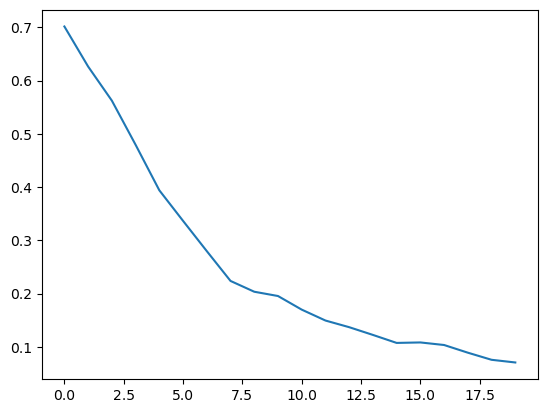

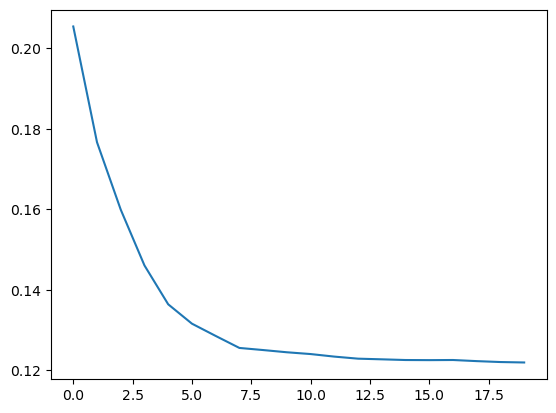

0:00:16.999228
epoch 20:, dice_loss=0.07482723, focal_loss=0.12203693, lr= 0.001
0:00:16.879752
epoch 21:, dice_loss=0.07265658, focal_loss=0.12194180, lr= 0.001
0:00:17.063816
epoch 22:, dice_loss=0.06665695, focal_loss=0.12197179, lr= 0.001
0:00:16.895127
epoch 23:, dice_loss=0.06511071, focal_loss=0.12195621, lr= 0.001
0:00:17.864632
epoch 24:, dice_loss=0.07037976, focal_loss=0.12200706, lr= 0.001
0:00:16.301166
epoch 25:, dice_loss=0.08167160, focal_loss=0.12216151, lr= 0.001
0:00:16.912358
epoch 26:, dice_loss=0.08238386, focal_loss=0.12201362, lr= 0.001
0:00:16.621184
epoch 27:, dice_loss=0.06961165, focal_loss=0.12200940, lr= 0.001
0:00:16.971618
epoch 28:, dice_loss=0.05875118, focal_loss=0.12185858, lr= 0.001
0:00:16.950850
epoch 29:, dice_loss=0.05742945, focal_loss=0.12183915, lr= 0.001


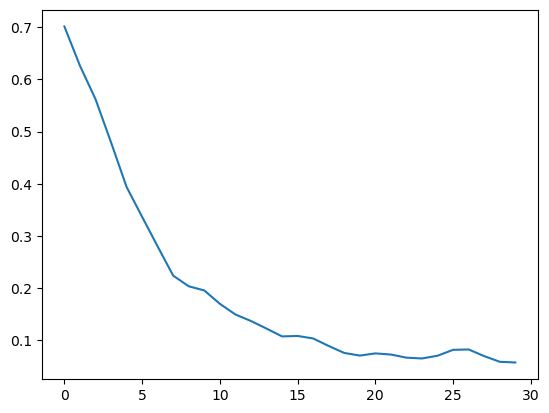

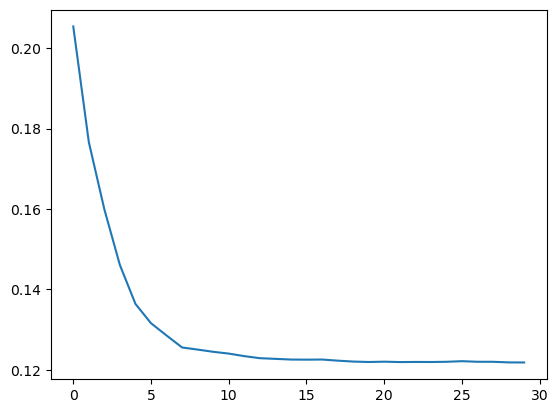

0:00:16.281877
epoch 30:, dice_loss=0.05402355, focal_loss=0.12179544, lr= 0.001
0:00:18.134363
epoch 31:, dice_loss=0.05286482, focal_loss=0.12178545, lr= 0.001
0:00:17.262614
epoch 32:, dice_loss=0.05148740, focal_loss=0.12175687, lr= 0.001
0:00:17.120954
epoch 33:, dice_loss=0.04982365, focal_loss=0.12176664, lr= 0.001
0:00:17.547478
epoch 34:, dice_loss=0.05449963, focal_loss=0.12172177, lr= 0.001
0:00:17.340060
epoch 35:, dice_loss=0.05428350, focal_loss=0.12182321, lr= 0.001
0:00:17.485053
epoch 36:, dice_loss=0.05422770, focal_loss=0.12181763, lr= 0.001
0:00:17.116468
epoch 37:, dice_loss=0.05097573, focal_loss=0.12172798, lr= 0.001
0:00:17.415134
epoch 38:, dice_loss=0.04819034, focal_loss=0.12169808, lr= 0.001
0:00:17.642242
epoch 39:, dice_loss=0.04714010, focal_loss=0.12170486, lr= 0.0005


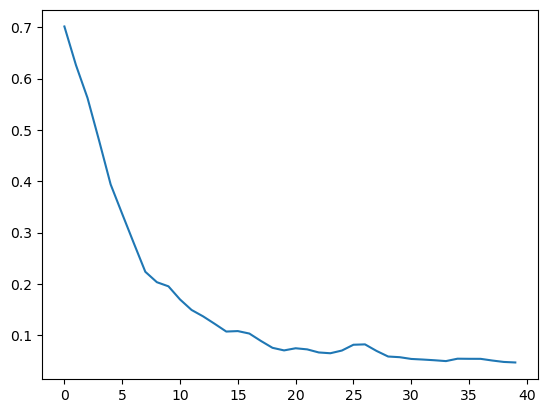

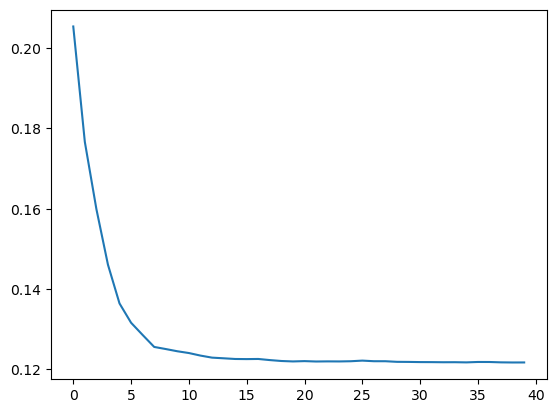

0:00:16.938311
epoch 40:, dice_loss=0.04489659, focal_loss=0.12158944, lr= 0.0005
0:00:16.966451
epoch 41:, dice_loss=0.04372004, focal_loss=0.12154118, lr= 0.0005
0:00:18.172527
epoch 42:, dice_loss=0.04293459, focal_loss=0.12158354, lr= 0.0005
0:00:16.887849
epoch 43:, dice_loss=0.04214014, focal_loss=0.12158720, lr= 0.0005
0:00:17.326608
epoch 44:, dice_loss=0.04197243, focal_loss=0.12155414, lr= 0.0005
0:00:16.704790
epoch 45:, dice_loss=0.04120364, focal_loss=0.12155240, lr= 0.0005
0:00:18.230326
epoch 46:, dice_loss=0.04064730, focal_loss=0.12153155, lr= 0.0005
0:00:17.788127
epoch 47:, dice_loss=0.04020227, focal_loss=0.12152288, lr= 0.0005
0:00:18.686102
epoch 48:, dice_loss=0.03969940, focal_loss=0.12151203, lr= 0.0005
0:00:16.770300
epoch 49:, dice_loss=0.04013458, focal_loss=0.12148797, lr= 0.0005


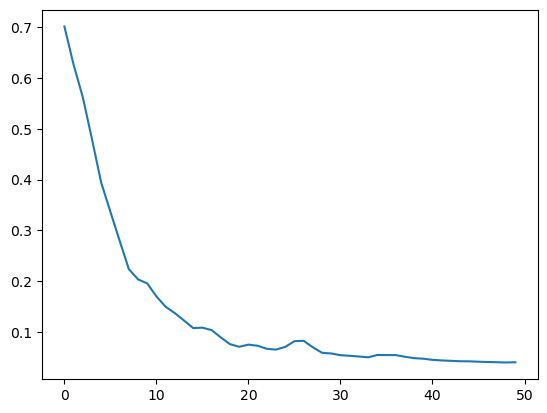

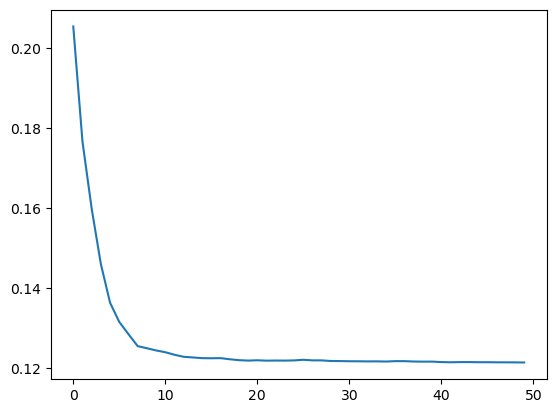

0:00:16.422744
epoch 50:, dice_loss=0.04183812, focal_loss=0.12154461, lr= 0.0005
0:00:15.986813
epoch 51:, dice_loss=0.04232079, focal_loss=0.12150093, lr= 0.0005
0:00:17.092240
epoch 52:, dice_loss=0.04296923, focal_loss=0.12156752, lr= 0.0005
0:00:16.031709
epoch 53:, dice_loss=0.04039281, focal_loss=0.12148619, lr= 0.0005
0:00:17.205348
epoch 54:, dice_loss=0.04387354, focal_loss=0.12153716, lr= 0.0005
0:00:17.512727
epoch 55:, dice_loss=0.05210557, focal_loss=0.12158131, lr= 0.0005
0:00:16.351202
epoch 56:, dice_loss=0.04697560, focal_loss=0.12158706, lr= 0.0005
0:00:17.792669
epoch 57:, dice_loss=0.04354542, focal_loss=0.12161997, lr= 0.0005
0:00:16.791290
epoch 58:, dice_loss=0.04188586, focal_loss=0.12153995, lr= 0.0005
0:00:17.773079
epoch 59:, dice_loss=0.03978138, focal_loss=0.12153149, lr= 0.0005


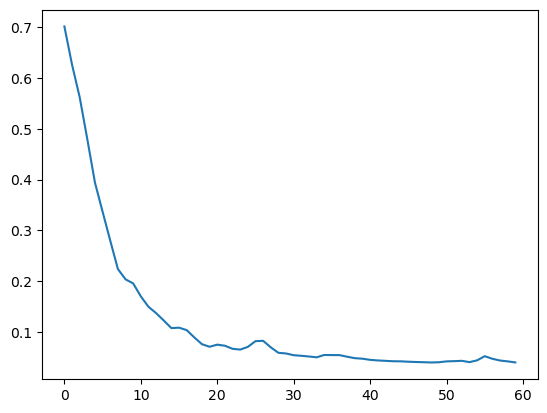

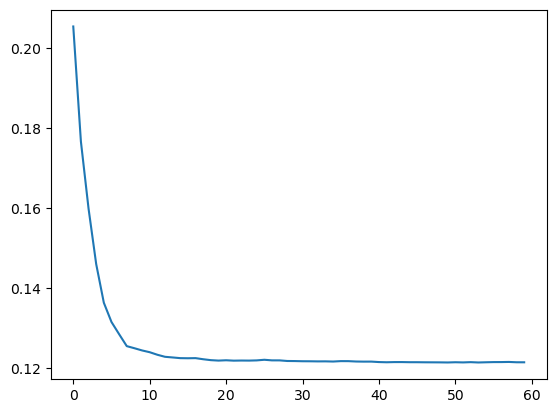

0:00:16.652380
epoch 60:, dice_loss=0.03856474, focal_loss=0.12147105, lr= 0.0005
0:00:16.662141
epoch 61:, dice_loss=0.03785579, focal_loss=0.12145791, lr= 0.0005
0:00:17.279923
epoch 62:, dice_loss=0.03748772, focal_loss=0.12142683, lr= 0.0005
0:00:17.324424
epoch 63:, dice_loss=0.03699315, focal_loss=0.12141500, lr= 0.0005
0:00:16.666634
epoch 64:, dice_loss=0.03695237, focal_loss=0.12141680, lr= 0.0005
0:00:17.316117
epoch 65:, dice_loss=0.04004792, focal_loss=0.12141818, lr= 0.0005
0:00:16.066970
epoch 66:, dice_loss=0.03765462, focal_loss=0.12141880, lr= 0.0005
0:00:16.706194
epoch 67:, dice_loss=0.03606634, focal_loss=0.12143474, lr= 0.0005
0:00:16.481079
epoch 68:, dice_loss=0.03790272, focal_loss=0.12138794, lr= 0.0005
0:00:17.893799
epoch 69:, dice_loss=0.04020125, focal_loss=0.12147591, lr= 0.0005


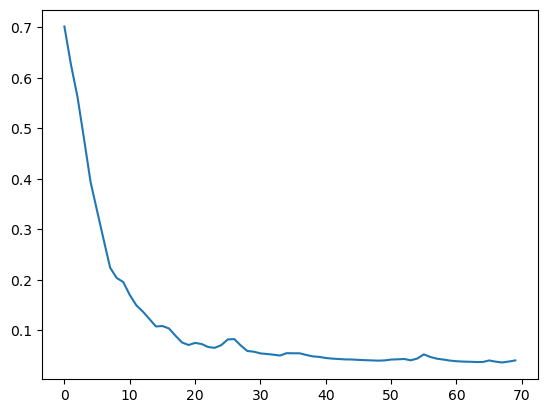

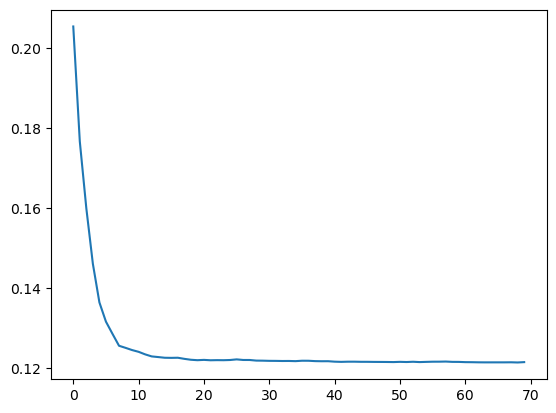

0:00:16.102763
epoch 70:, dice_loss=0.03633578, focal_loss=0.12139046, lr= 0.0005
0:00:15.545483
epoch 71:, dice_loss=0.03447362, focal_loss=0.12138604, lr= 0.0005
0:00:15.836383
epoch 72:, dice_loss=0.03368337, focal_loss=0.12134758, lr= 0.0005
0:00:15.970518
epoch 73:, dice_loss=0.03288227, focal_loss=0.12135308, lr= 0.0005
0:00:15.873132
epoch 74:, dice_loss=0.03297559, focal_loss=0.12132558, lr= 0.0005
0:00:15.918988
epoch 75:, dice_loss=0.03357946, focal_loss=0.12132914, lr= 0.0005
0:00:15.870339
epoch 76:, dice_loss=0.03179741, focal_loss=0.12127629, lr= 0.0005
0:00:15.794770
epoch 77:, dice_loss=0.03156267, focal_loss=0.12127574, lr= 0.0005
0:00:16.155032
epoch 78:, dice_loss=0.03211620, focal_loss=0.12129423, lr= 0.0005
0:00:15.917033
epoch 79:, dice_loss=0.03062692, focal_loss=0.12124893, lr= 0.00025


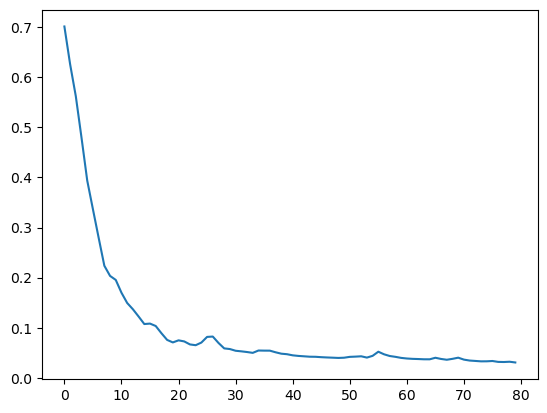

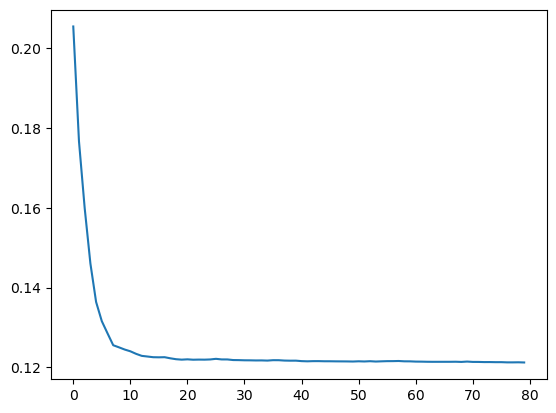

0:00:15.947827
epoch 80:, dice_loss=0.03026547, focal_loss=0.12126004, lr= 0.00025
0:00:15.878625
epoch 81:, dice_loss=0.03011451, focal_loss=0.12121645, lr= 0.00025
0:00:15.949384
epoch 82:, dice_loss=0.03023653, focal_loss=0.12124335, lr= 0.00025
0:00:16.105491
epoch 83:, dice_loss=0.03003842, focal_loss=0.12124337, lr= 0.00025
0:00:15.808831
epoch 84:, dice_loss=0.02987720, focal_loss=0.12123053, lr= 0.00025
0:00:15.019398
epoch 85:, dice_loss=0.02958278, focal_loss=0.12121971, lr= 0.00025
0:00:15.978212
epoch 86:, dice_loss=0.02961041, focal_loss=0.12122751, lr= 0.00025
0:00:15.903658
epoch 87:, dice_loss=0.02957105, focal_loss=0.12122124, lr= 0.00025
0:00:15.813632
epoch 88:, dice_loss=0.03015948, focal_loss=0.12119926, lr= 0.00025
0:00:15.060434
epoch 89:, dice_loss=0.02947999, focal_loss=0.12120980, lr= 0.00025


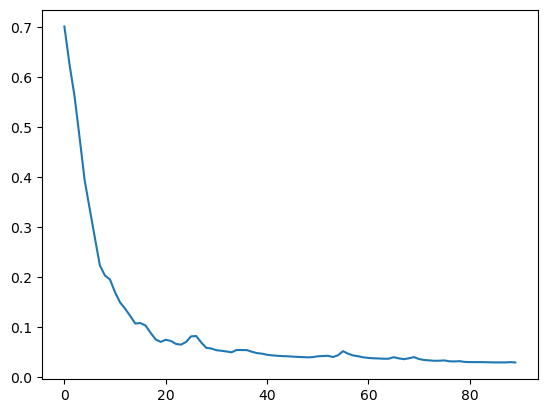

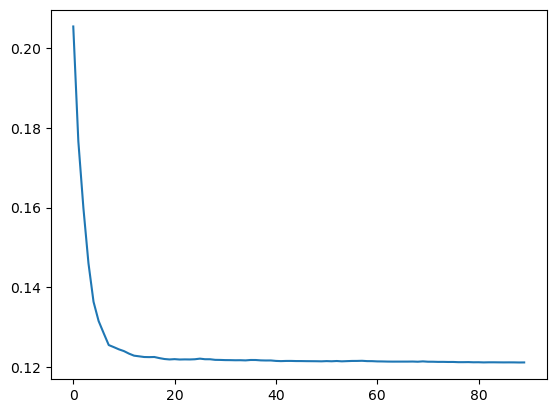

0:00:14.649493
epoch 90:, dice_loss=0.02955405, focal_loss=0.12121434, lr= 0.00025
0:00:16.075137
epoch 91:, dice_loss=0.02958225, focal_loss=0.12119680, lr= 0.00025
0:00:15.917595
epoch 92:, dice_loss=0.02855331, focal_loss=0.12118337, lr= 0.00025
0:00:16.282943
epoch 93:, dice_loss=0.02867387, focal_loss=0.12119298, lr= 0.00025
0:00:16.288545
epoch 94:, dice_loss=0.02920797, focal_loss=0.12120563, lr= 0.00025
0:00:16.359021
epoch 95:, dice_loss=0.02886652, focal_loss=0.12117270, lr= 0.00025
0:00:15.723342
epoch 96:, dice_loss=0.02813750, focal_loss=0.12117182, lr= 0.00025
0:00:15.661042
epoch 97:, dice_loss=0.02848891, focal_loss=0.12116159, lr= 0.00025
0:00:14.708208
epoch 98:, dice_loss=0.02753959, focal_loss=0.12116411, lr= 0.00025
0:00:15.265312
epoch 99:, dice_loss=0.02782118, focal_loss=0.12114294, lr= 0.00025


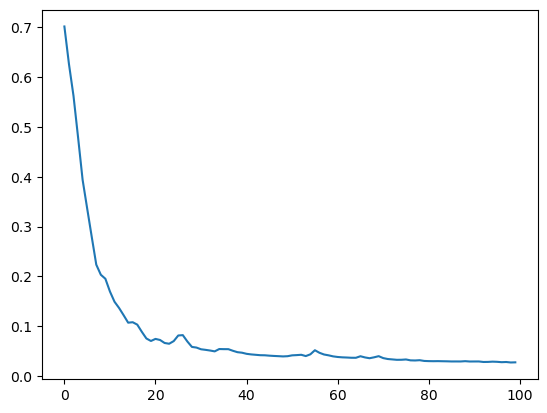

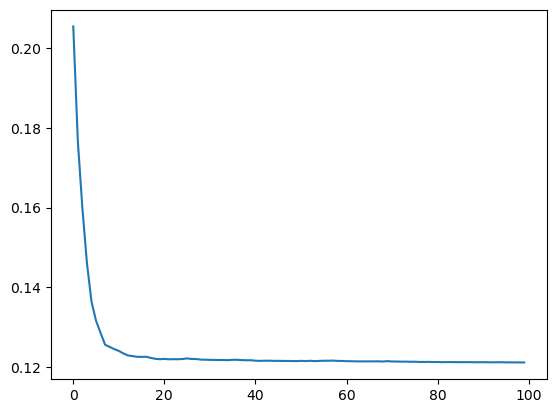

0:00:15.717467
epoch 100:, dice_loss=0.02731083, focal_loss=0.12113660, lr= 0.00025
0:00:15.132367
epoch 101:, dice_loss=0.03170760, focal_loss=0.12119519, lr= 0.00025
0:00:14.440884
epoch 102:, dice_loss=0.03085397, focal_loss=0.12120117, lr= 0.00025
0:00:14.464759
epoch 103:, dice_loss=0.02860758, focal_loss=0.12118332, lr= 0.00025
0:00:14.358743
epoch 104:, dice_loss=0.02840389, focal_loss=0.12116816, lr= 0.00025
0:00:14.941415
epoch 105:, dice_loss=0.02859555, focal_loss=0.12112001, lr= 0.00025
0:00:14.698347
epoch 106:, dice_loss=0.02685633, focal_loss=0.12113325, lr= 0.00025
0:00:14.876500
epoch 107:, dice_loss=0.02661023, focal_loss=0.12110084, lr= 0.00025
0:00:14.879879
epoch 108:, dice_loss=0.02629565, focal_loss=0.12111715, lr= 0.00025
0:00:14.570069
epoch 109:, dice_loss=0.02680109, focal_loss=0.12110260, lr= 0.00025


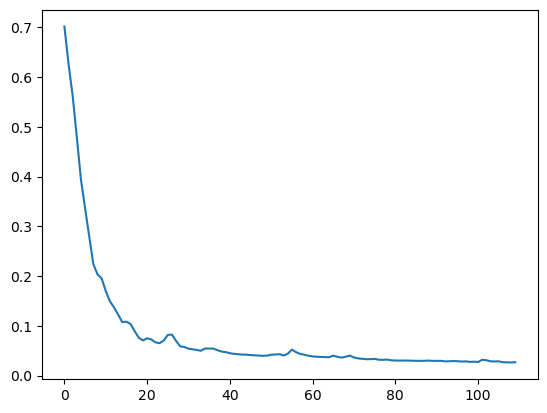

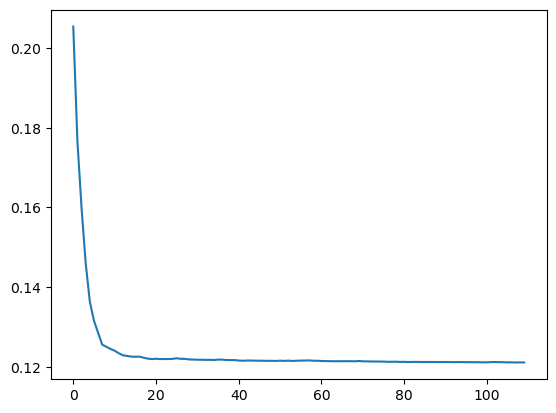

0:00:14.796206
epoch 110:, dice_loss=0.02600111, focal_loss=0.12109804, lr= 0.00025
0:00:14.785119
epoch 111:, dice_loss=0.02550066, focal_loss=0.12108642, lr= 0.00025
0:00:14.649285
epoch 112:, dice_loss=0.02555497, focal_loss=0.12108877, lr= 0.00025
0:00:14.924346
epoch 113:, dice_loss=0.02528442, focal_loss=0.12107865, lr= 0.00025
0:00:14.573523
epoch 114:, dice_loss=0.02501420, focal_loss=0.12107541, lr= 0.00025
0:00:14.884767
epoch 115:, dice_loss=0.02464645, focal_loss=0.12107095, lr= 0.00025
0:00:14.667692
epoch 116:, dice_loss=0.02478315, focal_loss=0.12107328, lr= 0.00025
0:00:14.657953
epoch 117:, dice_loss=0.02550452, focal_loss=0.12107924, lr= 0.00025
0:00:14.649983
epoch 118:, dice_loss=0.02592592, focal_loss=0.12106683, lr= 0.00025
0:00:14.791223
epoch 119:, dice_loss=0.02505348, focal_loss=0.12106053, lr= 0.000125


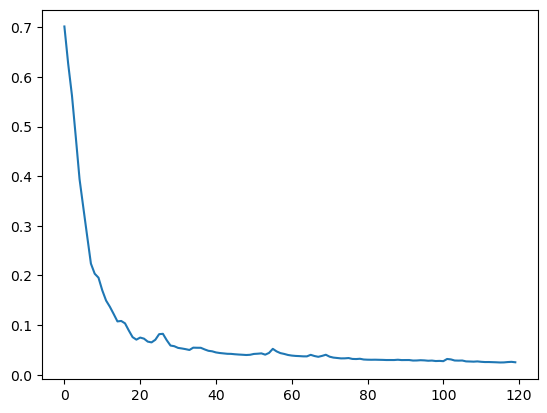

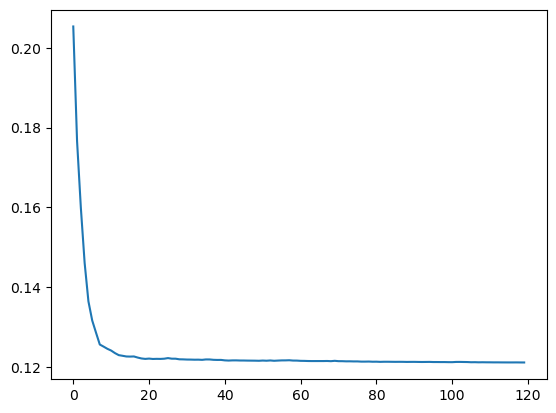

0:00:14.698443
epoch 120:, dice_loss=0.02488736, focal_loss=0.12108116, lr= 0.000125
0:00:14.765945
epoch 121:, dice_loss=0.02456023, focal_loss=0.12106498, lr= 0.000125
0:00:14.677414
epoch 122:, dice_loss=0.02451841, focal_loss=0.12107318, lr= 0.000125
0:00:14.812659
epoch 123:, dice_loss=0.02429582, focal_loss=0.12106104, lr= 0.000125
0:00:14.752157
epoch 124:, dice_loss=0.02454824, focal_loss=0.12106941, lr= 0.000125
0:00:15.141363
epoch 125:, dice_loss=0.02566353, focal_loss=0.12107264, lr= 0.000125
0:00:15.029495
epoch 126:, dice_loss=0.02403214, focal_loss=0.12105728, lr= 0.000125
0:00:15.480111
epoch 127:, dice_loss=0.02381491, focal_loss=0.12105899, lr= 0.000125
0:00:14.867979
epoch 128:, dice_loss=0.02353670, focal_loss=0.12105037, lr= 0.000125
0:00:14.645909
epoch 129:, dice_loss=0.02343046, focal_loss=0.12104727, lr= 0.000125


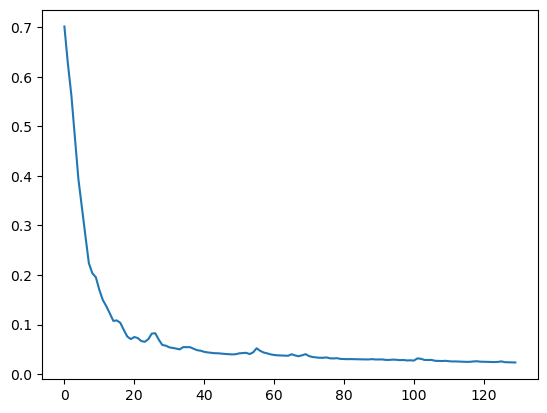

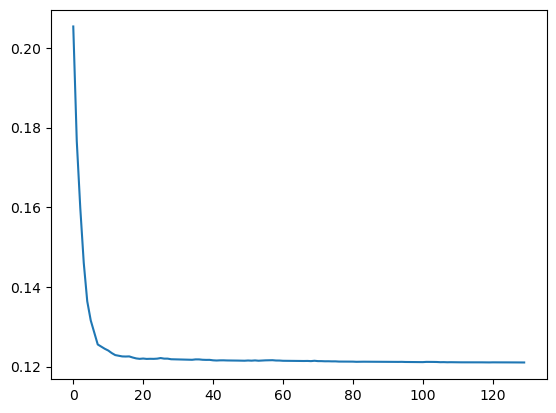

0:00:14.883231
epoch 130:, dice_loss=0.02299768, focal_loss=0.12104040, lr= 0.000125
0:00:14.965237
epoch 131:, dice_loss=0.02281276, focal_loss=0.12103975, lr= 0.000125
0:00:15.039515
epoch 132:, dice_loss=0.02256887, focal_loss=0.12103293, lr= 0.000125
0:00:15.132671
epoch 133:, dice_loss=0.02256981, focal_loss=0.12103394, lr= 0.000125
0:00:14.581384
epoch 134:, dice_loss=0.02254253, focal_loss=0.12103317, lr= 0.000125
0:00:14.780480
epoch 135:, dice_loss=0.02293259, focal_loss=0.12103812, lr= 0.000125
0:00:14.812696
epoch 136:, dice_loss=0.02252685, focal_loss=0.12102129, lr= 0.000125
0:00:14.984546
epoch 137:, dice_loss=0.02261442, focal_loss=0.12103255, lr= 0.000125
0:00:14.840722
epoch 138:, dice_loss=0.02278054, focal_loss=0.12102038, lr= 0.000125
0:00:14.693336
epoch 139:, dice_loss=0.02272771, focal_loss=0.12104089, lr= 0.000125


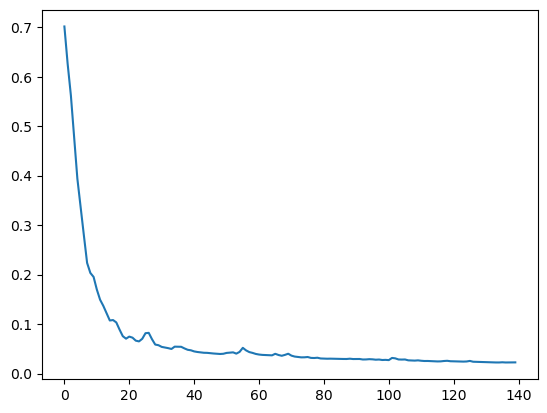

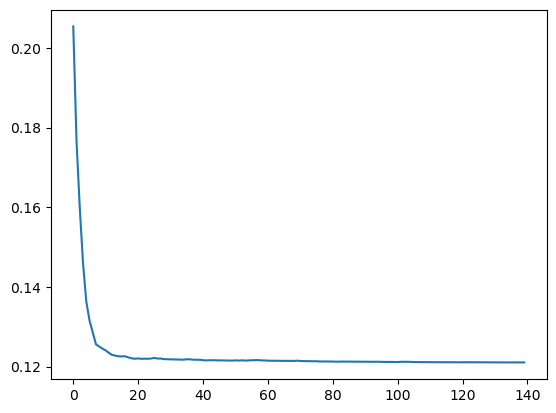

0:00:14.674726
epoch 140:, dice_loss=0.02249773, focal_loss=0.12101056, lr= 0.000125
0:00:14.922024
epoch 141:, dice_loss=0.02211952, focal_loss=0.12101546, lr= 0.000125
0:00:15.143755
epoch 142:, dice_loss=0.02213230, focal_loss=0.12101579, lr= 0.000125
0:00:14.845029
epoch 143:, dice_loss=0.02191404, focal_loss=0.12101587, lr= 0.000125
0:00:14.745028
epoch 144:, dice_loss=0.02191347, focal_loss=0.12101815, lr= 0.000125
0:00:14.845164
epoch 145:, dice_loss=0.02172263, focal_loss=0.12099953, lr= 0.000125
0:00:14.658779
epoch 146:, dice_loss=0.02198873, focal_loss=0.12103245, lr= 0.000125
0:00:14.648603
epoch 147:, dice_loss=0.02183972, focal_loss=0.12099462, lr= 0.000125
0:00:14.374803
epoch 148:, dice_loss=0.02159915, focal_loss=0.12100379, lr= 0.000125
0:00:14.267326
epoch 149:, dice_loss=0.02176530, focal_loss=0.12100442, lr= 0.000125


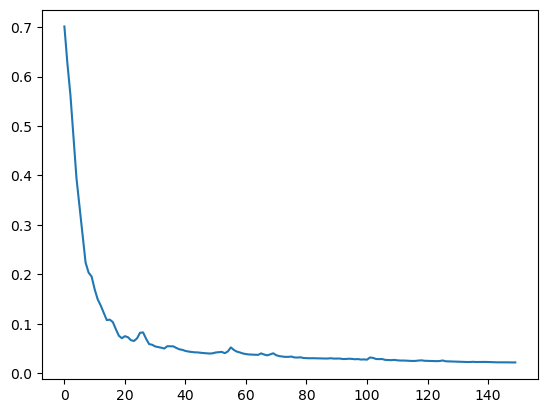

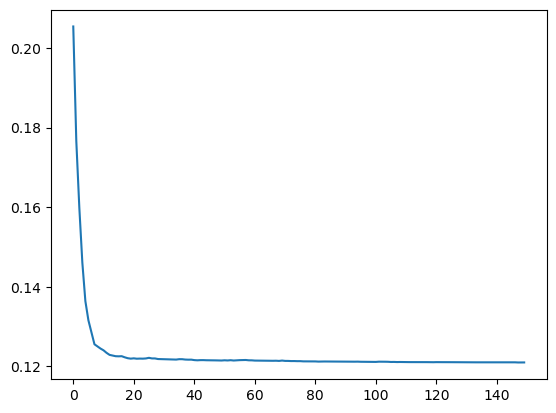

0:00:14.682646
epoch 150:, dice_loss=0.02187900, focal_loss=0.12101207, lr= 0.000125
0:00:14.539060
epoch 151:, dice_loss=0.02166952, focal_loss=0.12100608, lr= 0.000125
0:00:15.012718
epoch 152:, dice_loss=0.02227995, focal_loss=0.12100682, lr= 0.000125
0:00:14.907921
epoch 153:, dice_loss=0.02206878, focal_loss=0.12100103, lr= 0.000125
0:00:14.712799
epoch 154:, dice_loss=0.02149208, focal_loss=0.12099054, lr= 0.000125
0:00:14.672843
epoch 155:, dice_loss=0.02130683, focal_loss=0.12099949, lr= 0.000125
0:00:14.519191
epoch 156:, dice_loss=0.02119088, focal_loss=0.12099462, lr= 0.000125
0:00:14.758704
epoch 157:, dice_loss=0.02130811, focal_loss=0.12097583, lr= 0.000125
0:00:14.659216
epoch 158:, dice_loss=0.02106645, focal_loss=0.12099478, lr= 0.000125
0:00:14.929606
epoch 159:, dice_loss=0.02109956, focal_loss=0.12099923, lr= 6.25e-05


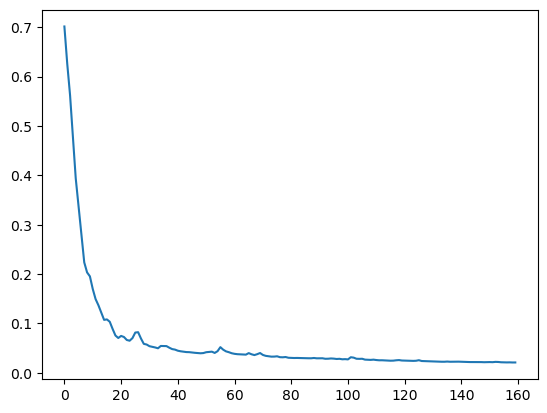

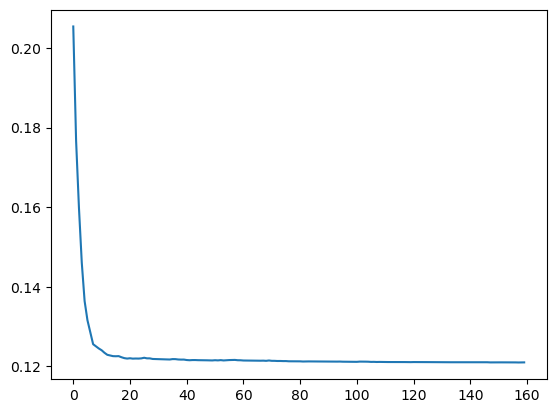

0:00:14.711408
epoch 160:, dice_loss=0.02135692, focal_loss=0.12097919, lr= 6.25e-05
0:00:14.729244
epoch 161:, dice_loss=0.02083018, focal_loss=0.12099294, lr= 6.25e-05
0:00:15.089879
epoch 162:, dice_loss=0.02056317, focal_loss=0.12097868, lr= 6.25e-05
0:00:14.710382
epoch 163:, dice_loss=0.02059818, focal_loss=0.12098695, lr= 6.25e-05
0:00:15.178554
epoch 164:, dice_loss=0.02053237, focal_loss=0.12098757, lr= 6.25e-05
0:00:15.214289
epoch 165:, dice_loss=0.02031849, focal_loss=0.12098109, lr= 6.25e-05
0:00:14.654285
epoch 166:, dice_loss=0.02021873, focal_loss=0.12098406, lr= 6.25e-05
0:00:14.848673
epoch 167:, dice_loss=0.02019834, focal_loss=0.12097689, lr= 6.25e-05
0:00:14.788865
epoch 168:, dice_loss=0.02027024, focal_loss=0.12098602, lr= 6.25e-05
0:00:14.826479
epoch 169:, dice_loss=0.02009222, focal_loss=0.12096758, lr= 6.25e-05


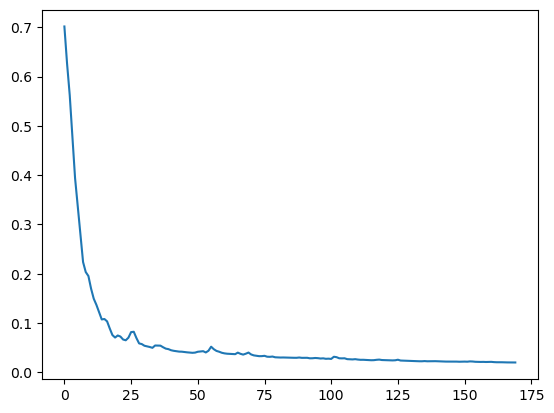

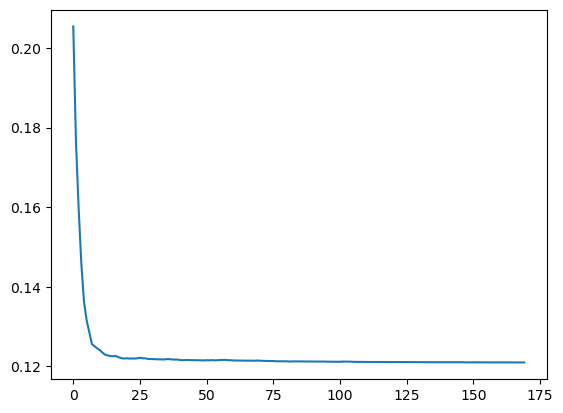

0:00:14.909684
epoch 170:, dice_loss=0.01988348, focal_loss=0.12097472, lr= 6.25e-05
0:00:14.822592
epoch 171:, dice_loss=0.01982091, focal_loss=0.12097780, lr= 6.25e-05
0:00:14.725245
epoch 172:, dice_loss=0.01977855, focal_loss=0.12096553, lr= 6.25e-05
0:00:14.797683
epoch 173:, dice_loss=0.01981395, focal_loss=0.12096995, lr= 6.25e-05
0:00:14.573007
epoch 174:, dice_loss=0.01978070, focal_loss=0.12096237, lr= 6.25e-05
0:00:14.522992
epoch 175:, dice_loss=0.01969599, focal_loss=0.12097391, lr= 6.25e-05
0:00:14.567505
epoch 176:, dice_loss=0.01977543, focal_loss=0.12096405, lr= 6.25e-05
0:00:14.588572
epoch 177:, dice_loss=0.01990056, focal_loss=0.12095914, lr= 6.25e-05
0:00:14.990297
epoch 178:, dice_loss=0.01984587, focal_loss=0.12097089, lr= 6.25e-05
0:00:14.632271
epoch 179:, dice_loss=0.01967252, focal_loss=0.12095752, lr= 6.25e-05


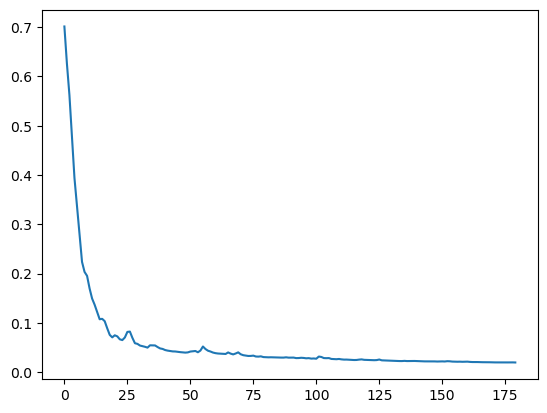

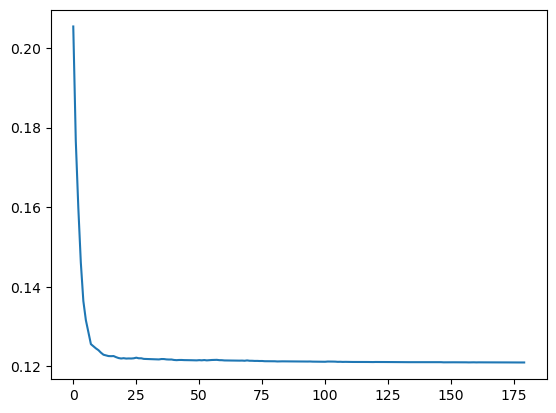

0:00:14.603213
epoch 180:, dice_loss=0.01949752, focal_loss=0.12095916, lr= 6.25e-05
0:00:15.037232
epoch 181:, dice_loss=0.01947879, focal_loss=0.12095697, lr= 6.25e-05
0:00:14.740102
epoch 182:, dice_loss=0.01935421, focal_loss=0.12096097, lr= 6.25e-05
0:00:15.151904
epoch 183:, dice_loss=0.01960768, focal_loss=0.12095370, lr= 6.25e-05
0:00:14.703536
epoch 184:, dice_loss=0.01962418, focal_loss=0.12095810, lr= 6.25e-05
0:00:14.868799
epoch 185:, dice_loss=0.01944586, focal_loss=0.12094943, lr= 6.25e-05
0:00:14.882086
epoch 186:, dice_loss=0.01930464, focal_loss=0.12096088, lr= 6.25e-05
0:00:14.520595
epoch 187:, dice_loss=0.01917921, focal_loss=0.12095100, lr= 6.25e-05
0:00:14.436263
epoch 188:, dice_loss=0.01922790, focal_loss=0.12094477, lr= 6.25e-05
0:00:14.376613
epoch 189:, dice_loss=0.01929505, focal_loss=0.12095658, lr= 6.25e-05


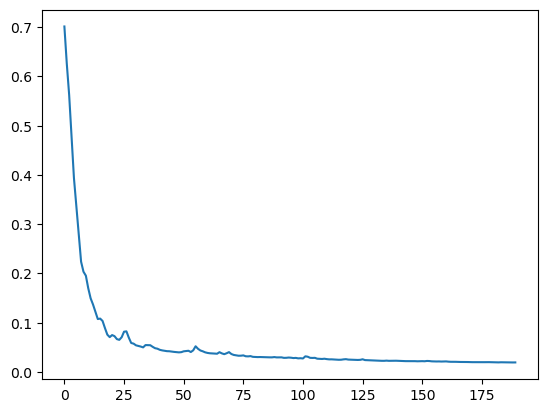

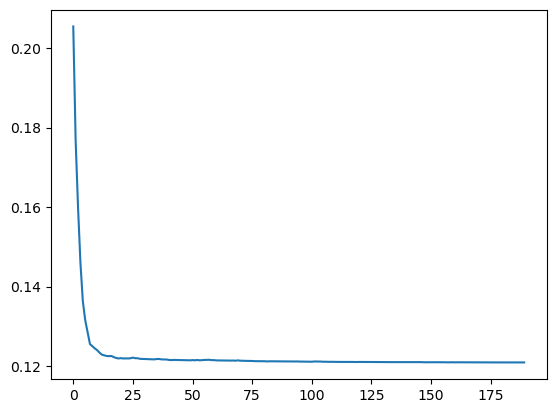

0:00:14.557836
epoch 190:, dice_loss=0.01933630, focal_loss=0.12095363, lr= 6.25e-05
0:00:14.568547
epoch 191:, dice_loss=0.01918233, focal_loss=0.12094752, lr= 6.25e-05
0:00:14.267276
epoch 192:, dice_loss=0.01910800, focal_loss=0.12094443, lr= 6.25e-05
0:00:14.711874
epoch 193:, dice_loss=0.01911891, focal_loss=0.12094890, lr= 6.25e-05
0:00:14.532839
epoch 194:, dice_loss=0.01910511, focal_loss=0.12094864, lr= 6.25e-05
0:00:14.748231
epoch 195:, dice_loss=0.01885461, focal_loss=0.12094448, lr= 6.25e-05
0:00:15.008543
epoch 196:, dice_loss=0.01894130, focal_loss=0.12094289, lr= 6.25e-05
0:00:14.659290
epoch 197:, dice_loss=0.01939188, focal_loss=0.12094507, lr= 6.25e-05
0:00:14.449083
epoch 198:, dice_loss=0.01919535, focal_loss=0.12093554, lr= 6.25e-05
0:00:14.789461
epoch 199:, dice_loss=0.01885833, focal_loss=0.12095416, lr= 3.125e-05


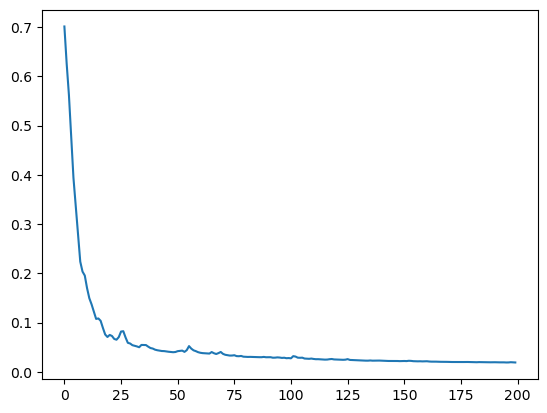

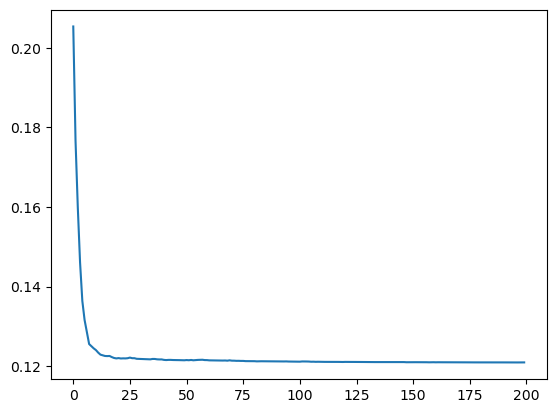

In [10]:
m.fit()

Validation

In [15]:
def calculate_dice(pred, mask):
    intersection = np.multiply(pred,mask)
    union  = np.sum(pred) + np.sum(mask)
    dice = (2 * np.sum(intersection))/union
    return dice
best_i = -1
best_dice = 0
for i in range(80,200):
    m.load_model(i)
    pred, masks = m.validate('val', 32)
    # pred = pred.astype(np.uint16)
    dice = 0
    t = 0
    for j  in range(len(pred)):
        if np.count_nonzero(masks[j]) != 0:
            dice += calculate_dice(masks[j], pred[j])
            t += 1
    dice /= t
    print('epoch = ', i,'dice = ', dice)
    if dice > best_dice:
        best_i = i
        best_dice = dice
print('best_i = ', best_i)

epoch =  80 dice =  0.9642182046516902
epoch =  81 dice =  0.9618778027487459
epoch =  82 dice =  0.9580280932858436
epoch =  83 dice =  0.9544703106605743
epoch =  84 dice =  0.9655808820594185
epoch =  85 dice =  0.9497804869053056
epoch =  86 dice =  0.9502079843496845
epoch =  87 dice =  0.9622158866209157
epoch =  88 dice =  0.95473655524887
epoch =  89 dice =  0.9617169915267785
epoch =  90 dice =  0.9588099882391565
epoch =  91 dice =  0.9644076379161187
epoch =  92 dice =  0.9644813028424876
epoch =  93 dice =  0.9521227001664755
epoch =  94 dice =  0.9632746313034993
epoch =  95 dice =  0.9670017522714477
epoch =  96 dice =  0.963054643660666
epoch =  97 dice =  0.9652827701527782
epoch =  98 dice =  0.9660171352646425
epoch =  99 dice =  0.9647967085633856
epoch =  100 dice =  0.9649595762175975
epoch =  101 dice =  0.9403566948002003
epoch =  102 dice =  0.9606009660929092
epoch =  103 dice =  0.9233896854948563
epoch =  104 dice =  0.9571900143856363
epoch =  105 dice =  0.

epoch =  69 dice =  0.9588099882391565


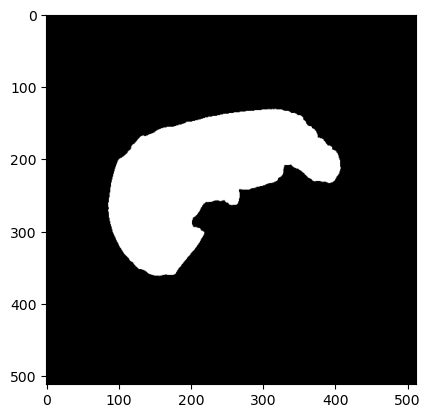

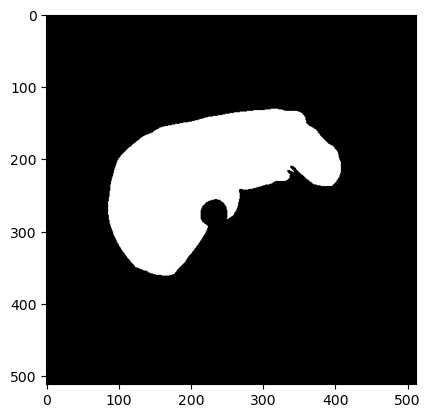

In [12]:
def calculate_dice(pred, mask):
    intersection = np.multiply(pred,mask)
    union  = np.sum(pred) + np.sum(mask)
    dice = (2 * np.sum(intersection))/union
    return dice
m.load_model(90)
pred, masks = m.validate('val', 32)
dice = 0
t = 0
for j  in range(len(pred)):
    if np.count_nonzero(masks[j]) != 0:
        dice += calculate_dice(masks[j], pred[j])
        t += 1
dice /= t
print('epoch = ', 69,'dice = ', dice)
plt.imshow(pred[25], cmap = 'gray')
plt.show()
plt.imshow(masks[25], cmap = 'gray')

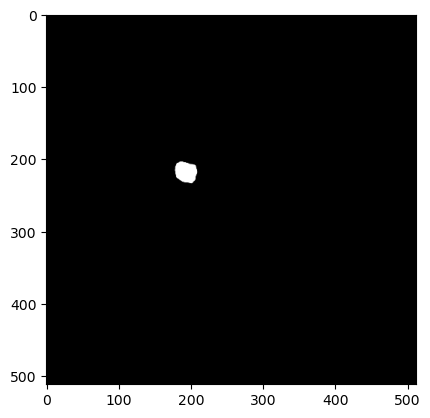

0.8460899331547439


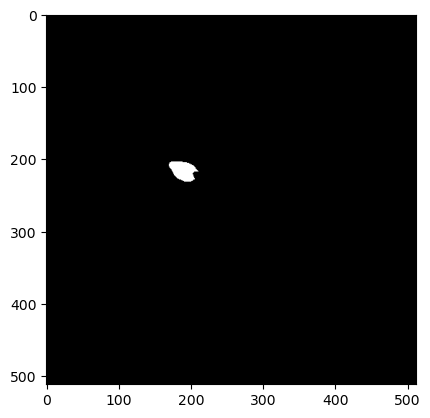

In [13]:
i = 0
plt.imshow(pred[i], cmap = 'gray')
plt.show()
plt.imshow(masks[i], cmap = 'gray')
dice = calculate_dice(masks[i], pred[i])
print(dice)

##Test

In [16]:
m.load_model(best_i)
save_path = '/bulk/liangy15/CHAOS/CHAOS_submission_template_2/Task2/CT'
pred, folders = m.validate('test', 32)
for j in range(len(pred)):
    if folders[j] != folders[j-1]: 
        k = 0
    save_folder = os.path.join(save_path,str(folders[j]),'Results')
    save_name = os.path.join(save_folder,'img{:0>3}.png'.format(k))
    plt.imsave(save_name, pred[j], cmap = 'gray')
    k += 1
